In [1]:
import numpy as np
from io_utils import loadGraph, permuteNoiseMat, writeEdgesToFile

A = loadGraph('facebook/0.edges', 'u')

rest_bool = list(np.sum(A, axis=0) != 0) or list(np.sum(A, axis=1) != 0)
rest_idx = [i for i in xrange(len(rest_bool)) if rest_bool[i]]
A = A[rest_idx, :]
A = A[:, rest_idx]

B, P = permuteNoiseMat(A,is_perm =True, has_noise=False)

writeEdgesToFile('metadata/A.edges', A)
writeEdgesToFile('metadata/B.edges', B)


In [2]:
from attr_utils import *

attributesA = getUndirAttribute('metadata/A.edges')
with open('metadata/attributesA', 'w') as f:
    for index, row in attributesA.iterrows():
        f.write(str(attributesA.ix[index]))

attributesB = getUndirAttribute('metadata/B.edges')
with open('metadata/attributesB', 'w') as f:
    for index, row in attributesB.iterrows():
        f.write(str(attributesB.ix[index]))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Degree


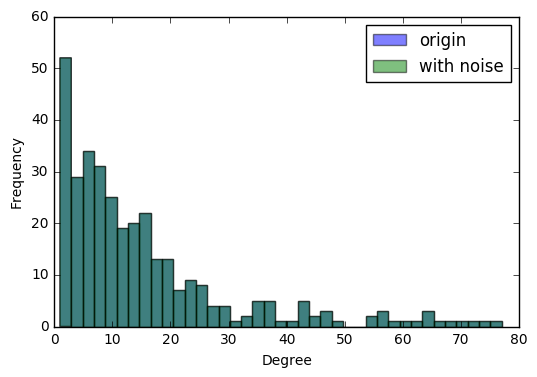

NodeBetweennessCentrality


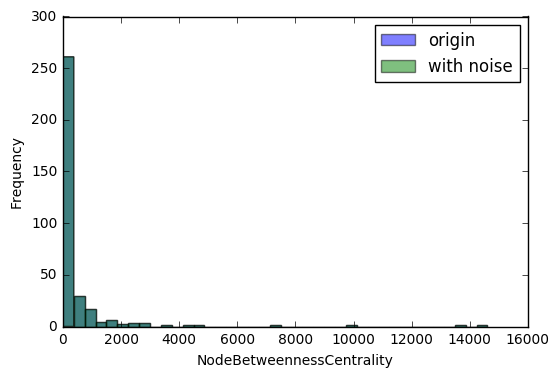

FarnessCentrality


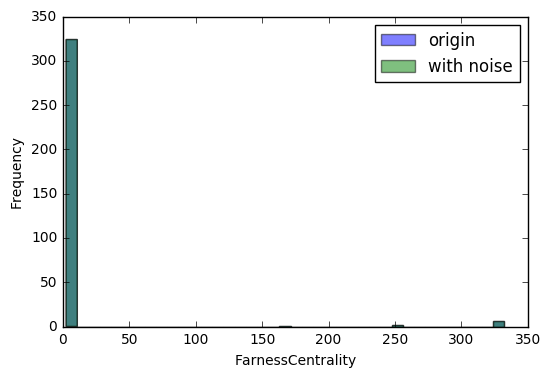

PageRank


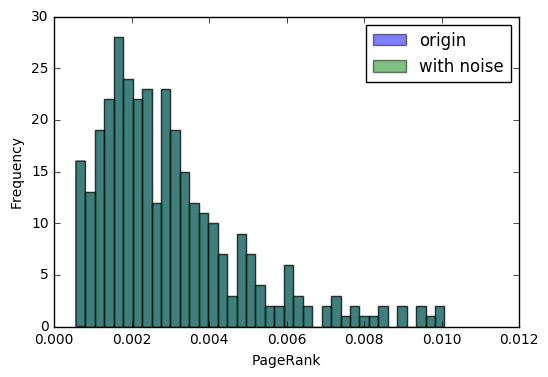

NodeEccentricity


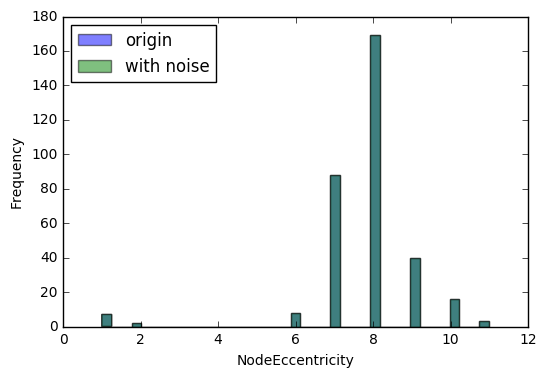

In [3]:
# plot attributes distributin against noise
import matplotlib.pyplot as plt

attributes = ['Degree', 'NodeBetweennessCentrality', 
                      'FarnessCentrality', 'PageRank', 'NodeEccentricity']
plt.clf()
for attr in attributes:
    print attr
    plt.figure()
    bins = np.linspace(min(min(attributesA[attr]), min(attributesB[attr])), max(max(attributesA[attr]), max(attributesB[attr])), 40)
    plt.hist(attributesA[attr], bins, alpha=0.5, label='origin')
    plt.hist(attributesB[attr], bins, alpha=0.5, label='with noise')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

In [ ]:
from attr_utils import *
from lsh_utils import *

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity']

for i in range(len(attributes)-1):
    for j in range(i+1, len(attributes)):
        print 'KL Divergence of %s and %s' %(attributes[i], attributes[j]), KL_sim(attributesA[attributes[i]], attributesA[attributes[j]])


In [4]:
from lsh_utils import *

combineAB = selectAndCombine(attributesA, attributesB)

bandDeg = ['Degree','PageRank']
bucketDeg = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandDeg), 20)
with open('metadata/buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketEdge = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandEdge), 20)
with open('metadata/buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateCosineBuckets(selectAndCombine(attributesA, attributesB, bandAll), 20)
print len(bucketAll.items())

buckets = [bucketDeg, bucketEdge]

9
23
44


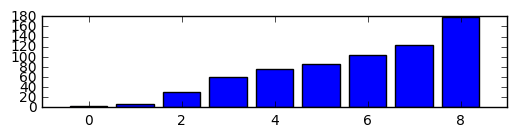

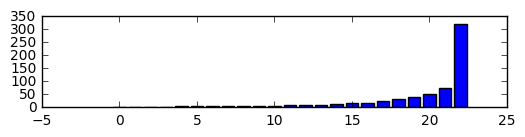

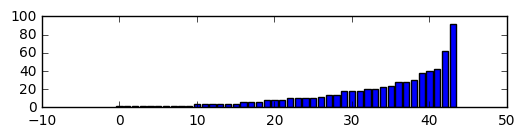

In [7]:
#plot cosine bucket distribution
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(313)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

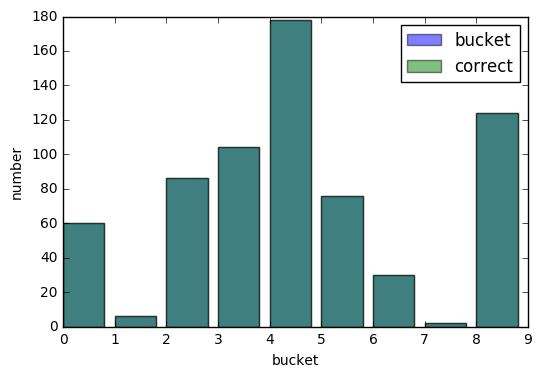

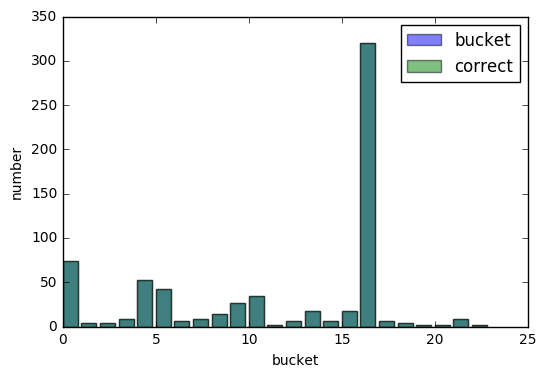

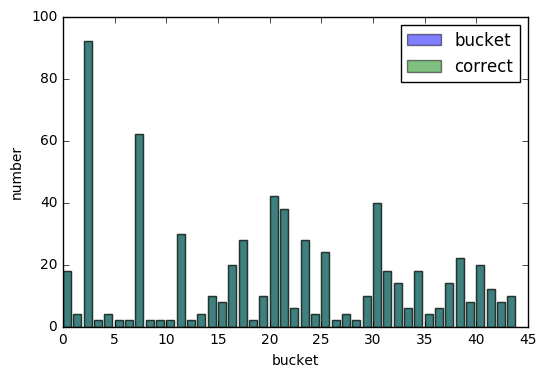

In [8]:
# plot cosine bucket correctness
def plotCorrectness(d, n):
    correct = {}
    for v, k in d.items():
        cnt = 0
        for i in k:
            if (i < n):
                if (i + n in k):
                    cnt += 2
            else:
                break
        correct[v] = cnt
    plt.clf
    plt.figure()
    plt.bar(range(len(d)), [len(v) for k,v in d.items()], alpha=0.5, label='bucket', color='blue')
    plt.bar(range(len(correct)), [correct[k] for k,v in d.items()], alpha=0.5, label='correct', color='green')
    plt.xlabel('bucket')
    plt.ylabel('number')
    plt.legend(loc='best')
    plt.show()
    
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [9]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB)
Ranking = Rank(matching_matrix, P)

In [10]:
show_list = [0, 10, 20, 50]
top_k = 5
for i in show_list:
    print "cos sim top %d for node %d:" %(top_k, attributesA['Id'][i])
    print attributesB['Id'][sim_matrix[i].argsort()[-top_k:]].values
    print "matching top %d for node %d:"%(top_k, attributesA['Id'][i])
    print attributesB['Id'][matching_matrix[i].argsort()[-top_k:]].values


cos sim top 5 for node 1:
[17 23 31  5  1]
matching top 5 for node 1:
[15 11 37 23  1]
cos sim top 5 for node 11:
[ 6 19 23 15 11]
matching top 5 for node 11:
[140   1  23  15  11]
cos sim top 5 for node 21:
[90 49 60  8 21]
matching top 5 for node 21:
[160 240 191   8  21]
cos sim top 5 for node 51:
[27 37 39 64 51]
matching top 5 for node 51:
[ 87  99 102  64  51]


In [ ]:
bandDeg = ['Degree','PageRank']
bucketDeg = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandDeg), 2)
with open('metadata/euc-buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketEdge = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandEdge), 2)
with open('metadata/euc-buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB, bandAll), 2)
print len(bucketAll.items())
buckets = [bucketDeg, bucketEdge]

In [ ]:
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(312)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

In [ ]:
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [ ]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict)
sim_matrix = computeWholeSimMat(attributesA, attributesB)
Ranking = Rank(matching_matrix, P)